# 001 Tests on how to extend the stellarflow system to a `tf-agents` compatible RL-Env.

Inspiration: https://towardsdatascience.com/creating-a-custom-environment-for-tensorflow-agent-tic-tac-toe-example-b66902f73059

In [355]:
## Imports
import sys
sys.path.append("./source/")

import stellarflow as stf
import numpy as np
import tensorflow as tf

## Settings
AU, ED = stf.System._AU, stf.System._ED

## Checking if GPU is used
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("NO GPU FOUND!")

In [356]:
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

In [357]:
## TODO: Plan: Create a py_environment based on the stellarfow.system and wrapping it in a TFPyEnvironment

In [358]:
test = np.concatenate([np.array([1, 2]), np.array([2, 3])], axis=0)
np.array(test)

array([1, 2, 2, 3])

In [359]:
class stfaEnv(py_environment.PyEnvironment):
    ## TODO: Implement mass / propellant consumtion
    def __init__(self, 
            mass: float,
            initial_location: np.ndarray, 
            initial_velocity: np.ndarray, 
            target_point: np.ndarray,
            stfSystem: stf.System,
            target_point_relative: bool=False,
            target_point_relative_to: int=None,
            reward_factor_boost: float=1.0,
            reward_factor_target_distance: float=1.0):

        ## Additional Information for spacecraft
        self._m = mass
        self._x = np.array(initial_location)
        self._y = np.array(initial_velocity)
        q = np.concatenate([initial_location, initial_velocity], axis=0)
        self._q = tf.Variable(q, dtype=tf.float32)
        self._reward_factor_boost = reward_factor_boost
        self._reward_factor_target_distance = reward_factor_target_distance

        ## Target Location for rewards
        self._target = tf.constant(target_point, dtype=tf.float32)
        self._target_point_relative = target_point_relative
        if target_point_relative and target_point_relative_to is None:
            print("No target point reference object ('target_point_relative_to') provided, using first object of System.")
            self._target_point_relative_to = 0
        else:
            self._target_point_relative_to = target_point_relative_to

        ## Binding with stf.System:
        temp = np.concatenate([stfSystem._Q.numpy(), np.expand_dims(self._q, axis=0)], axis=0)
        stfSystem._Q = tf.Variable(temp, dtype=tf.float32)
        stfSystem._Q_hist = tf.cast(tf.expand_dims(stfSystem._Q, axis=0), dtype=tf.float32)
        stfSystem._mask_reps, stfSystem._mask_len, stfSystem._mask = stfSystem._create_mask(stfSystem._Q.shape[0])
        stfSystem.masses = np.concatenate([stfSystem.masses, [mass]], axis=0)
        stfSystem._M = stfSystem._reshape_masses(stfSystem.masses)
        self._sys = stfSystem

        ## State for max iterations
        self.n_iter = 0

        ## Providing for tfa-py_env
        self._action_spec = array_spec.BoundedArraySpec(shape=(3,), dtype=np.float32, name="boost")
        self._observation_spec = array_spec.ArraySpec(self._sys._Q.shape, dtype=np.float32, name="q-vector")
        self._state = self._sys._Q.numpy()
        self._initial_q = self._sys._Q
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = self._initial_q.numpy()
        self._episode_ended = False
        self._sys._reset()
        return ts.restart(self._state)

    def __compute_target_distance(self):
        # TODO: Target point might need to be a function of steps, which needs to get hand designed for flexibility (e. g. Lagrange Points).
        if self._target_point_relative:
            target = self._target + self._sys._Q[self._target_point_relative_to, :3]
            return target - self._q[:3]
        else:
            return self._target - self._q[:3]

    def __calc_new_mass(self):
        # TODO: Effect of boosting (propellant consumption)
        return self._m

    @tf.function
    def _accelerations_plus_boost(self, Q):
        return self._sys._acceleration(Q) + self._current_boost

    def _step(self, action: np.ndarray):
        self.n_iter += 1

        if self._episode_ended:
        # The last action ended the episode. Ignore the current action and start
        # a new episode.
            return self.reset()

        # Adding the booth to the acceleations of system
        # accelerations = self._sys._acceleration(self._sys._Q)
        boost = tf.Variable(tf.zeros_like(self._sys._Q, dtype=self._sys._Q.dtype)) 
        boost[-1, 3:].assign(tf.constant(action, dtype=boost.dtype))
        self._current_boost = boost / self.__calc_new_mass()
        # accelerations_boosted = accelerations + boost / self.__calc_new_mass()
        
        # Performing a system step
        Q = self._sys._solver_rkf(self._sys._Q, self._accelerations_plus_boost)
        self._sys._Q_hist = tf.concat([self._sys._Q_hist, [Q]], axis=0)
        self._sys._Q = Q
        self._q = Q[-1]
        self._state = self._sys._Q.numpy()

        # Bounding episode length
        if self._episode_ended or self.n_iter > 1000:
            reward = 0.0
            return ts.termination(self._state, reward)

        # Rewarding with boost length and distance to target
        else:
            distance = np.linalg.norm(self.__compute_target_distance())
            target = self._sys._Q[self._target_point_relative_to]
            reward = -self._reward_factor_boost*np.linalg.norm(action) - self._reward_factor_target_distance*distance
            return ts.transition(
                np.array(self._state, dtype=np.float32), reward=reward, discount=1.0)


## Testing

In [360]:
X = np.array([
    [0., 0.,    0.], # Sun 
    [1., 0.,    0.], # Earth
    [0., 1.524, 0.]  # Mars
])

V = np.array([
    [0.,           0., 0.], # Sun 
    [0., 29290./AU*ED, 0.],  # Earth
    [27070./AU*ED, 0., 0.],  # Mars
])

M = np.array([
    1.,                # Sun
    3.0025e-6,         # Earth
    0.107 * 3.0025e-6  # Mars
])

SEM_system = stf.System(X, V, M)

In [361]:
env = stfaEnv(mass=1e-28, initial_location=[1.1, 0., 0.], initial_velocity=[0., 0.01, 0.], target_point=[2., 0., 0.], stfSystem=SEM_system)

In [362]:
fixed_boost = 1e-32*np.array([1., 0., 0.])

In [363]:
for _ in range(100):
    env._step(fixed_boost)

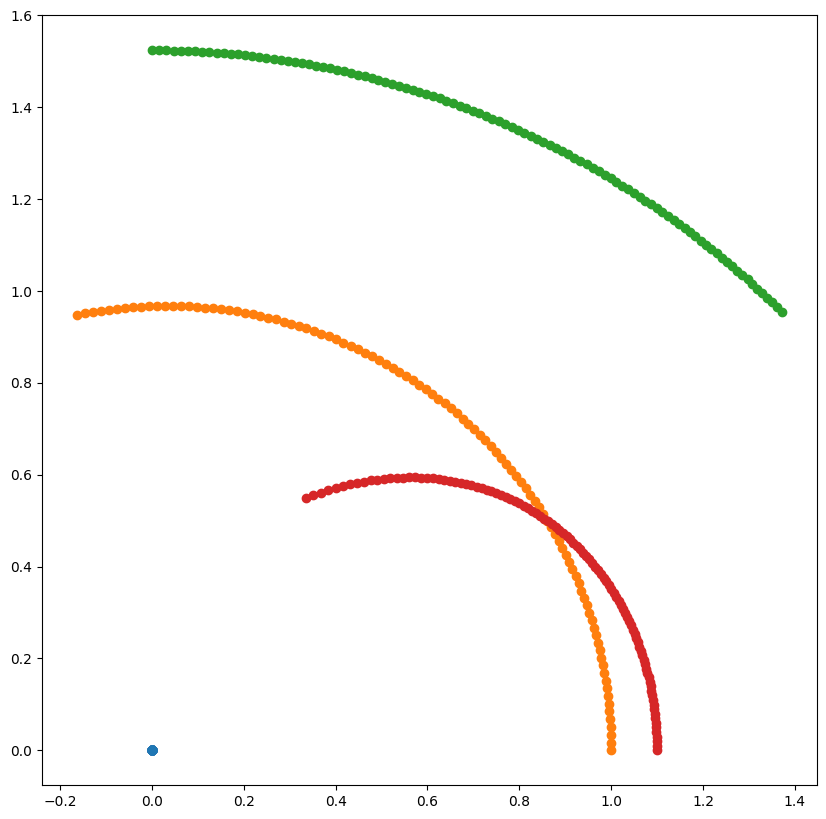

In [351]:
SEM_system.plot_history_2d()

In [352]:
utils.validate_py_environment(env, episodes=1)

## Trying to make the env a tf_env

In [353]:
del env
SEM_system._reset()

In [354]:
SEM_system = stf.System(X, V, M)
env = stfaEnv(mass=1e-28, initial_location=[1.1, 0., 0.], initial_velocity=[0., 0.01, 0.], target_point=[2., 0., 0.], stfSystem=SEM_system)
tf_env = tf_py_environment.TFPyEnvironment(env)
print(isinstance(tf_env, tf_environment.TFEnvironment))
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())

True
TimeStep Specs: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': TensorSpec(shape=(4, 6), dtype=tf.float32, name='q-vector'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Action Specs: BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='boost', minimum=array(-3.4028235e+38, dtype=float32), maximum=array(3.4028235e+38, dtype=float32))
